# Parallel Programming with Dask in Python

Python is now well established as a major platform for data analysis and data science. For many data scientists, the largest limitation of Python is that all data must fit into the resident memory of the available workstation. Further, traditionally, Python has only been able to utilize one CPU. Data scientists constantly ask, "How can I read and process large amounts of data?" and "How can I make use of more computational processing resources?" This course will introduce you to Dask, a flexible parallel computing library for analytic computing. With Dask, you will be able to take the Python workflows you currently have and easily scale them up to large datasets on your workstation without the need to migrate to a distributed computing environment.

## Working with Big Data

In this chapter you'll learn how to leverage traditional Python techniques for reading and processing large datasets stored in either a single file or in multiple files. Finally, you'll learn how the Dask library can be used to execute a pipeline of Python functions in parallel with the added goal of being able to process large amounts of data on modest computational resources. For this course, the data set sizes have been reduced so that the exercises can be completed rapidly. Many of these data sets were originally several Gigabytes in size.

### NumPy transformations
Many NumPy transformations, while fast, use one or more temporary arrays. Therefore, those transformations require more storage than the original array required.

An array of temperature values in Celsius is provided for you as celsius. Your job is to monitor memory consumption while applying NumPy vectorized operations. The data comes from The Weather Underground.

In [4]:
# Define memory_footprint
import psutil, os
def memory_footprint():
    '''Returns memory (in MB) being used by Python process'''
    mem = psutil.Process(os.getpid()).memory_info().rss
    return (mem / 1024 ** 2)

# read csv
import pandas as pd

data = pd.read_csv('ATL.csv')

celsius = data['Mean TemperatureF']

print(celsius.head())

# Print the size in MB of the celsius array
print(celsius.nbytes/1024**2)

# Call memory_footprint(): before
before = memory_footprint()

# Convert celsius by multiplying by 9/5 and adding 32: fahrenheit
fahrenheit = celsius *9/5 + 32

# Call memory_footprint(): after
after = memory_footprint()

# Print the difference between after and before
print(after - before)
print(after - before)

0    43
1    41
2    44
3    39
4    35
Name: Mean TemperatureF, dtype: int64
0.0027923583984375
0.23828125
0.23828125


### Filtering WDI data in chunks
Using the World Bank's World Development Indicators (or WDI) dataset, you're going to plot the percentage of the population of Australia in urban centers since 1980.

Your job is to loop over chunks of the WDI dataset; from each chunk, you will filter out rows describing Australia's "percent urban population." You'll then concatenate the filtered chunks and plot the results.

In [8]:
# Create empty list: dfs
dfs = []

# Loop over 'WDI.csv'
for chunk in pd.read_csv('WDI.csv', chunksize= 1000):
    # Create the first Series
    is_urban = chunk['Indicator Name']=='Urban population (% of total)'
    # Create the second Series
    is_AUS = chunk['Country Code']=='AUS'

    # Create the filtered chunk: filtered
    filtered = chunk.loc[is_urban & is_AUS]

    # Append the filtered chunk to the list dfs
    dfs.append(filtered)

### Concatenating & plotting WDI data
In the previous exercise, you read a large CSV file by chunks, performed boolean filtering on each chunk, and stored each filtered chunk in a list. Before filtering, each chunk contained up to 1000 rows. However, after filtering, some of the filtered chunks had no rows. You'll now use len() to determine the number of chunks and the actual number of rows that the filter retains.

Your job is to use pd.concat() to make a single DataFrame from the list dfs; this list is provided for you. The function pd.concat() will take the list of DataFrames and concatenate them into a new DataFrame object. Finally, you will plot the results. The modules matplotlib.pyplot and pandas have been imported for you with standard aliases (plt and pd respectively).

92
36


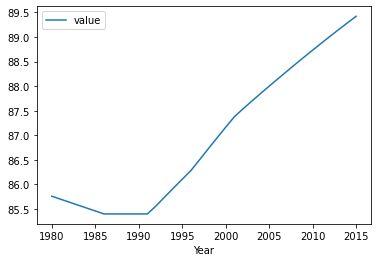

In [14]:
# Print length of list dfs
print(len(dfs))

# Apply pd.concat to dfs: df
df = pd.concat(dfs)

# Print length of DataFrame df
print(len(df))

# Call df.plot.line with x='Year' and y='value'
df.plot.line(x='Year', y='value')


### Computing percentage of delayed flights
Multiple CSV files of flight information have been provided from the Bureau of Transportation Statistics. Each file contains one month of information in 2016.

Your first job is to build a function to compute the percentage of delayed flights given a DataFrame of flight information. Your function will take a single DataFrame as input and compute the percentage of its rows in which the 'DEP_DELAY' value is greater than zero.

In [15]:
# Define function with single input called df: pct_delayed
def pct_delayed(df):
    # Compute number of delayed flights: n_delayed
    n_delayed = (df['DEP_DELAY']>0).sum()
    # Return percentage of delayed flights
    return n_delayed  * 100 / len(df)

### Generating & plotting delayed flights
Now that you have a function to compute flight delays, you'll apply it with a generator to analyze the percentage of delayed flights for each month of 2016.

You'll create a generator expression to loop over the provided list filenames and return a sequence of DataFrames. For each DataFrame, you'll then apply the function pct_delayed() (provided for you) within a list comprehension.

[33.452587898839234, 30.28061856399731, 34.17446750780084, 30.687246141348496, 33.20086366054385]


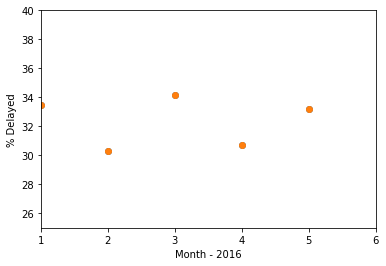

In [24]:
# define filenames
filenames = ['flightdelays-2016-1.csv',
 'flightdelays-2016-2.csv',
 'flightdelays-2016-3.csv',
 'flightdelays-2016-4.csv',
 'flightdelays-2016-5.csv']

# Define the generator: dataframes
dataframes = (pd.read_csv(file) for file in filenames)

# Create the list comprehension: monthly_delayed
monthly_delayed = [pct_delayed(df) for df in dataframes]

print(monthly_delayed)


# Create the plot
import matplotlib.pyplot as plt
x = range(1,6)
plt.plot(x, monthly_delayed, marker='o', linewidth=0)
plt.plot(x, monthly_delayed, marker='o', linewidth=0)
plt.ylabel('% Delayed')
plt.xlabel('Month - 2016')
plt.xlim((1,6))
plt.ylim((25,40))
plt.show()

### Building a pipeline with delayed
If we use dask.delayed, we don't need to use generators; the dask scheduler will manage memory usage. In this version of the flight delay analysis, you'll compute the total yearly percentage of delayed flights.

Along with pandas, the decorator function delayed has been imported for you from dask, and the following decorated function, which calls pd.read_csv() on a single file, has been created for you:

Your job is to define three decorated functions to complete the pipeline: a function to total the number of flights, a function to count the number of delayed flights, and a function to aggregate the results.

In [29]:
# import dask
from dask import delayed

@delayed
def read_one(filename):
    return pd.read_csv(filename)

# Define count_flights
@delayed
def count_flights(df):
    return len(df)

# Define count_delayed
@delayed
def count_delayed(df):
    return (df['DEP_DELAY']>0).sum()

# Define pct_delayed
@delayed
def pct_delayed(n_delayed,n_flights):
    return 100 * sum(n_delayed) / sum(n_flights)

### Computing pipelined results
Now that the dask.delayed functions are defined, we can use them to construct the pipeline of delayed tasks.

Your job is to loop over the file names, store the temporary information in lists, and aggregate the final result. Two empty lists, n_delayed, and n_flights, have been created for you.

The distinction here is that we are working with dask.delayed functions and objects, not real, computed values. The computation will only be executed when you call .compute() on the final result (by contrast with earlier exercises).

In [32]:
# Loop over the provided filenames list and call read_one: df

n_delayed = []
n_flights = []

for file in filenames:
    df = read_one(file)

    # Append to n_delayed and n_flights
    n_delayed.append(count_delayed(df))
    n_flights.append(count_flights(df))

# Call pct_delayed with n_delayed and n_flights: result
result = pct_delayed(n_delayed, n_flights)

# Print the output of result.compute()
print(result.compute())

32.406252934201824
